In [1]:
# Create a code to avoid all types of warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)
warnings.filterwarnings(action="ignore",category=UserWarning)

In [2]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append("..")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
# from src.utils import week_of_month, plot_kpis
pd.options.display.float_format = '{:.4f}'.format
sns.set_theme()
import arviz as az
#import preliz as pz

# Problema Case Ifood
> Objetivo: Entender o impacto dos investimentos em mídia nos indicadores de desempenho (tráfego e engajamento do usuário) e fornecer recomendações estratégicas para otimizar o gasto com mídia.


> Desafio: Identificar quais canais de mídia estão impulsionando os KPIs e como otimizar o orçamento de mídia.

## Import data

In [3]:
medias = ["cinema","digital","influ","newpapers","offline","radio","social","tv","other_medias"]
medias_with_more_investment = ["tv", "other_medias", "digital", "offline", "influ", "social"]

In [4]:
from src.prepare_data import load_data, agg_by_week
df = load_data('/Users/marianebando/Documents/Git/projeto_ifood')
df_week = agg_by_week(df)
df_week.head()

,weeks_from_start,date,traffic,notifications_sent,n_active_users,event1,event2,cinema,digital,influ,newpapers,offline,radio,social,tv,other_medias,holiday,month,week_of_month,has_media_investment
0,1,2007-01-15,567597,179553,12523,0,0,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0,0,2007-01,2,False
1,2,2007-01-22,560370,198023,12523,1,0,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0,0,2007-01,3,False
2,3,2007-01-29,568526,195984,12523,1,0,0.0000,27987.0800,0.0000,0,0.0000,0.0000,0.0000,0.0000,0,0,2007-01,4,False
3,4,2007-02-05,600621,180884,12805,1,0,0.0000,24452.3200,0.0000,0,0.0000,0.0000,0.0000,0.0000,0,0,2007-02,1,False
4,5,2007-02-12,597438,172550,12805,1,0,0.0000,69532.3000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0,0,2007-02,2,False


# Applying effects

In [5]:
from src.utils.carryover_effect import ExponentialCarryover
from src.utils.saturation_effect import SaturationTransformation
from src.utils.seasonality_effect import get_seasonality

import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Aplicando um Adstock simples

In [6]:
from src.utils.carryover_effect import decay_function, ExponentialCarryover
# prior knowledge
half_life_media = {
    "cinema": 3,
    "digital": 2,
    "influ": 1,
    "newpapers": 2,
    "offline": 4,
    "radio": 2,
    "social": 1,
    "tv": 3,
    "other_medias": 1,
}
lag_media = {
    "cinema": 1,
    "digital": 0,
    "influ": 0,
    "newpapers": 1,
    "offline": 2,
    "radio": 1,
    "social": 0,
    "tv": 1,
    "other_medias": 0,
}
# write decay function using half life for each media
decay_media = {m: decay_function(half_life) for m, half_life in half_life_media.items()}

for media in medias:
    df_week[media] = ExponentialCarryover(decay_factor = decay_media[media], L = lag_media[media]+1, func = "geo").fit_transform(df_week[media])
decay_media

{'cinema': 0.7937005259840998,
 'digital': 0.7071067811865476,
 'influ': 0.5,
 'newpapers': 0.7071067811865476,
 'offline': 0.8408964152537145,
 'radio': 0.7071067811865476,
 'social': 0.5,
 'tv': 0.7937005259840998,
 'other_medias': 0.5}

In [7]:
channel_priors = {
    "cinema": 0.02,
    "digital": 0.14,
    "influ": 0.08,
    "newpapers": 0.03,
    "offline": 0.05,
    "radio": 0.01,
    "social": 0.08,
    "tv": 0.01,
    "other_medias": 0.05,
}


# Adicionando Sazonalidade

In [13]:
# Fourier terms
degree = 2
seasonality_prior = 0.05 / (2*degree)
trend_prior = 0.05
holiday_prior = 0.05

from src.utils.seasonality_effect import get_seasonality
seasonality = get_seasonality(df_week, period=52, degree=degree)
df_week = pd.concat([df_week, seasonality], axis =1)

In [9]:
def hill_transform(x, alpha, gamma):
    return 1 / (1 + (x/gamma)**-alpha)

In [14]:
import pytensor.tensor as pt
import pymc as pm
import arviz as az
import numpy as np

# Funções auxiliares
def scale(x, y):
    return x * y.sum() / x.sum()

def scale_investments(x):
    return x / 100_000  # Divisão por 100k

def build_model(df):
    with pm.Model() as mmm:
        target = df['traffic'].values.reshape(-1, 1) / df['traffic'].mean()

        media_contributions = []
        for channel in channel_priors.keys():
            channel_prior = channel_priors[channel]
            channel_coefficient = pm.TruncatedNormal(f"coefficient_{channel}", mu=channel_prior, sigma=0.0001, lower=0, upper=0.15)

            # Saturation
            lambda_ = pm.Uniform(f"alpha_{channel}", lower=0.1, upper=1)
            max_effect = pm.Uniform(f"gamma_{channel}", lower=0.1, upper=1.5)
            saturated_media = SaturationTransformation(
                lambda_=lambda_, 
                max_effect=max_effect, 
                function_curve="exponential"
            ).fit_transform(scale_investments(df[channel].values.reshape(-1, 1)))

            scaled_media = scale(saturated_media, target)

            # Contribution
            channel_contribution = pm.Deterministic(f"contribution_{channel}", channel_coefficient * scaled_media)
            media_contributions.append(channel_contribution)

        # Controls
        holiday_coefficient = pm.TruncatedNormal("coefficient_holiday", mu=holiday_prior, sigma=0.0001, lower=0)
        controls = pm.Deterministic("contribution_holiday", holiday_coefficient * scale(pt.as_tensor_variable(df['holiday'].values.reshape(-1, 1)), target))

        # Trend
        trend_coefficient = pm.Normal("coefficient_trend", mu=trend_prior, sigma=0.0001)
        trend = pm.Deterministic("contribution_trend", trend_coefficient)

        # Seasonality
        seasonality = []
        for i in np.arange(1, degree+1):
            coeff_cos = pm.Normal(f"coefficient_seasonality_cos_{i}", mu=seasonality_prior, sigma=0.0001)
            coeff_sin = pm.Normal(f"coefficient_seasonality_sin_{i}", mu=seasonality_prior, sigma=0.0001)
            cos_term = pm.Deterministic(f"contribution_seasonality_cos_{i}", coeff_cos * df[f"cos_{i}"].values.reshape(-1, 1) * target.sum()/26)
            sin_term = pm.Deterministic(f"contribution_seasonality_sin_{i}", coeff_sin * df[f"sin_{i}"].values.reshape(-1, 1) * target.sum()/26)
            seasonality.extend([cos_term, sin_term])

        # Intercept and Noise
        intercept_coefficient = pm.TruncatedNormal("coefficient_intercept", mu=0.5, sigma=0.0001, lower=0)
        intercept = pm.Deterministic("contribution_intercept", intercept_coefficient * target.mean())
        noise = pm.Uniform("sigma", lower=0, upper=0.02)

        # Likelihood
        mu = intercept + trend + controls + pt.sum(seasonality, axis=0) + pt.sum(media_contributions, axis=0)
        likelihood = pm.Normal("traffic", mu=mu, sigma=noise, observed=target)

    return mmm


In [15]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_week, test_size = 0.2, random_state = 42, shuffle=False) # shuffle False to keep the order
print(f"Train set from week {int(df_train.index.min())} to {int(df_train.index.max())}")
print(f"Test set from week {int(df_test.index.min())} to {int(df_test.index.max())}")

Train set from week 0 to 52
Test set from week 53 to 66


In [17]:
model_train = build_model(df_train)
# Inference
with model_train:
    trace = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coefficient_cinema, alpha_cinema, gamma_cinema, coefficient_digital, alpha_digital, gamma_digital, coefficient_influ, alpha_influ, gamma_influ, coefficient_newpapers, alpha_newpapers, gamma_newpapers, coefficient_offline, alpha_offline, gamma_offline, coefficient_radio, alpha_radio, gamma_radio, coefficient_social, alpha_social, gamma_social, coefficient_tv, alpha_tv, gamma_tv, coefficient_other_medias, alpha_other_medias, gamma_other_medias, coefficient_holiday, coefficient_trend, coefficient_seasonality_cos_1, coefficient_seasonality_sin_1, coefficient_seasonality_cos_2, coefficient_seasonality_sin_2, coefficient_intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 92 seconds.


In [20]:
import pickle
# Supondo que `trace` seja o objeto retornado pelo ajuste do modelo
with open('/Users/marianebando/Documents/Git/projeto_ifood/models/pymc_model.joblib', 'wb') as f:
    pickle.dump(trace, f)


In [25]:
df_train.shape, df_test.shape

((53, 24), (14, 24))

In [22]:
model_test = build_model(df_test)
# Inference
with model_test:
    var_names=["traffic"] + [f"contribution_{channel}" for channel in channel_priors.keys()]
    ppc_all = pm.sample_posterior_predictive(
        trace, random_seed=42, var_names=var_names
    )
    # az.plot_ppc(az.from_pymc3(posterior_predictive=ppc_all), var_names=["traffic"])

Sampling: [traffic]


TypeError: ("The type's shape ((14, 1)) is not compatible with the data's ((53, 1))", 'Container name "contribution_holiday"')

In [27]:
def build_model(df):
    with pm.Model() as mmm:
        target = df['traffic'].values.reshape(-1, 1) / df['traffic'].mean()

        media_contributions = []
        for channel in channel_priors.keys():
            channel_prior = channel_priors[channel]
            channel_coefficient = pm.TruncatedNormal(f"coefficient_{channel}", mu=channel_prior, sigma=0.0001, lower=0, upper=0.15)

            # Saturation
            lambda_ = pm.Uniform(f"alpha_{channel}", lower=0.1, upper=1)
            max_effect = pm.Uniform(f"gamma_{channel}", lower=0.1, upper=1.5)
            saturated_media = SaturationTransformation(
                lambda_=lambda_, 
                max_effect=max_effect, 
                function_curve="exponential"
            ).fit_transform(scale_investments(df[channel].values.reshape(-1, 1)))

            scaled_media = scale(saturated_media, target)

            # Contribution
            channel_contribution = pm.Deterministic(f"contribution_{channel}", channel_coefficient * scaled_media)
            media_contributions.append(channel_contribution)

        # Controls
        holiday_coefficient = pm.TruncatedNormal("coefficient_holiday", mu=holiday_prior, sigma=0.0001, lower=0)
        controls = pm.Deterministic("contribution_holiday", holiday_coefficient * scale(pt.as_tensor_variable(df['holiday'].values.reshape(-1, 1)), target))

        # Trend
        trend_coefficient = pm.Normal("coefficient_trend", mu=trend_prior, sigma=0.0001)
        trend = pm.Deterministic("contribution_trend", trend_coefficient)

        # Seasonality
        seasonality = []
        for i in np.arange(1, degree+1):
            coeff_cos = pm.Normal(f"coefficient_seasonality_cos_{i}", mu=seasonality_prior, sigma=0.0001)
            coeff_sin = pm.Normal(f"coefficient_seasonality_sin_{i}", mu=seasonality_prior, sigma=0.0001)
            cos_term = pm.Deterministic(f"contribution_seasonality_cos_{i}", coeff_cos * df[f"cos_{i}"].values.reshape(-1, 1) * target.sum()/26)
            sin_term = pm.Deterministic(f"contribution_seasonality_sin_{i}", coeff_sin * df[f"sin_{i}"].values.reshape(-1, 1) * target.sum()/26)
            seasonality.extend([cos_term, sin_term])

        # Intercept and Noise
        intercept_coefficient = pm.TruncatedNormal("coefficient_intercept", mu=0.5, sigma=0.0001, lower=0)
        intercept = pm.Deterministic("contribution_intercept", intercept_coefficient * target.mean())
        noise = pm.Uniform("sigma", lower=0, upper=0.02)

        # Likelihood
        mu = intercept + trend + controls + pt.sum(seasonality, axis=0) + pt.sum(media_contributions, axis=0)
        likelihood = pm.Normal("traffic", mu=mu, sigma=noise, observed=target)

    return mmm

In [ ]:
# Verificação das dimensões
print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_test: {df_test.shape}")

model_train = build_model(df_train)
with model_train:
    trace = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True, random_seed=42)

In [ ]:
model_test = build_model(df_test)
with model_test:
    var_names = ["traffic"] + [f"contribution_{channel}" for channel in channel_priors.keys()]
    ppc_all = pm.sample_posterior_predictive(
        trace, random_seed=42, var_names=var_names
    )


In [93]:
# get all media contributions
media_contributions = {k: float(trace.posterior["contribution_"+k].mean()) for k in medias}
media_contributions

{'cinema': 0.018749448428277617,
 'digital': 0.1396586804501682,
 'influ': 0.07944075521257211,
 'newpapers': 0.029288725208932807,
 'offline': 0.049630213954058665,
 'radio': 0.00954804569795253,
 'social': 0.07951035750603697,
 'tv': 0.009705089119500451,
 'other_medias': 0.04969169240526411}

Text(0.5, 1.0, 'Model Fit')

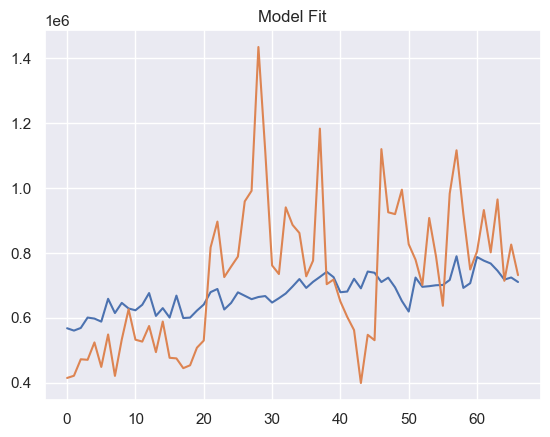

In [ ]:
predictions = ppc_all['posterior_predictive']['traffic'].mean(axis=0).mean(axis=0) * df_week['traffic'].mean()

df_week_decomp = pd.DataFrame(media_contributions, index=df_week.date) * df_week['traffic'].mean()

plt.plot(df_week['traffic'])
plt.plot(predictions)
plt.title("Model Fit")

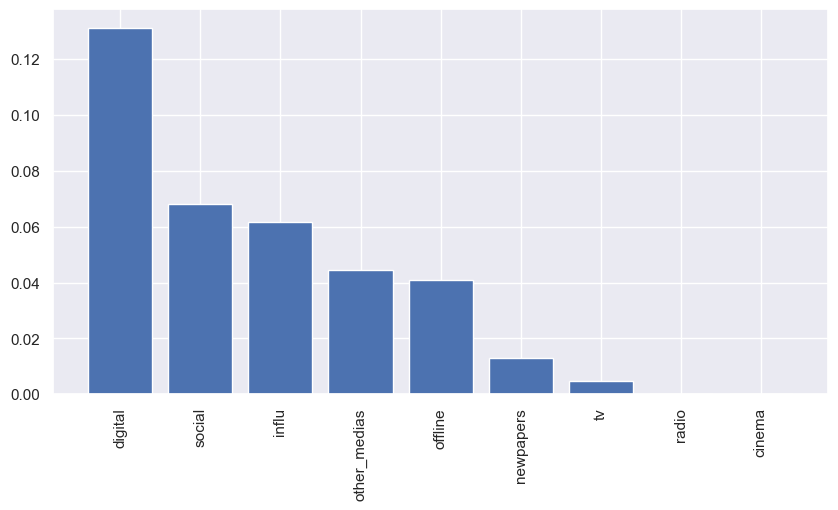

In [40]:
# plot all media contributions
# sort by value
media_contributions = dict(sorted(media_contributions.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(10,5))
plt.bar(media_contributions.keys(), media_contributions.values())
plt.xticks(rotation=90)
plt.show()

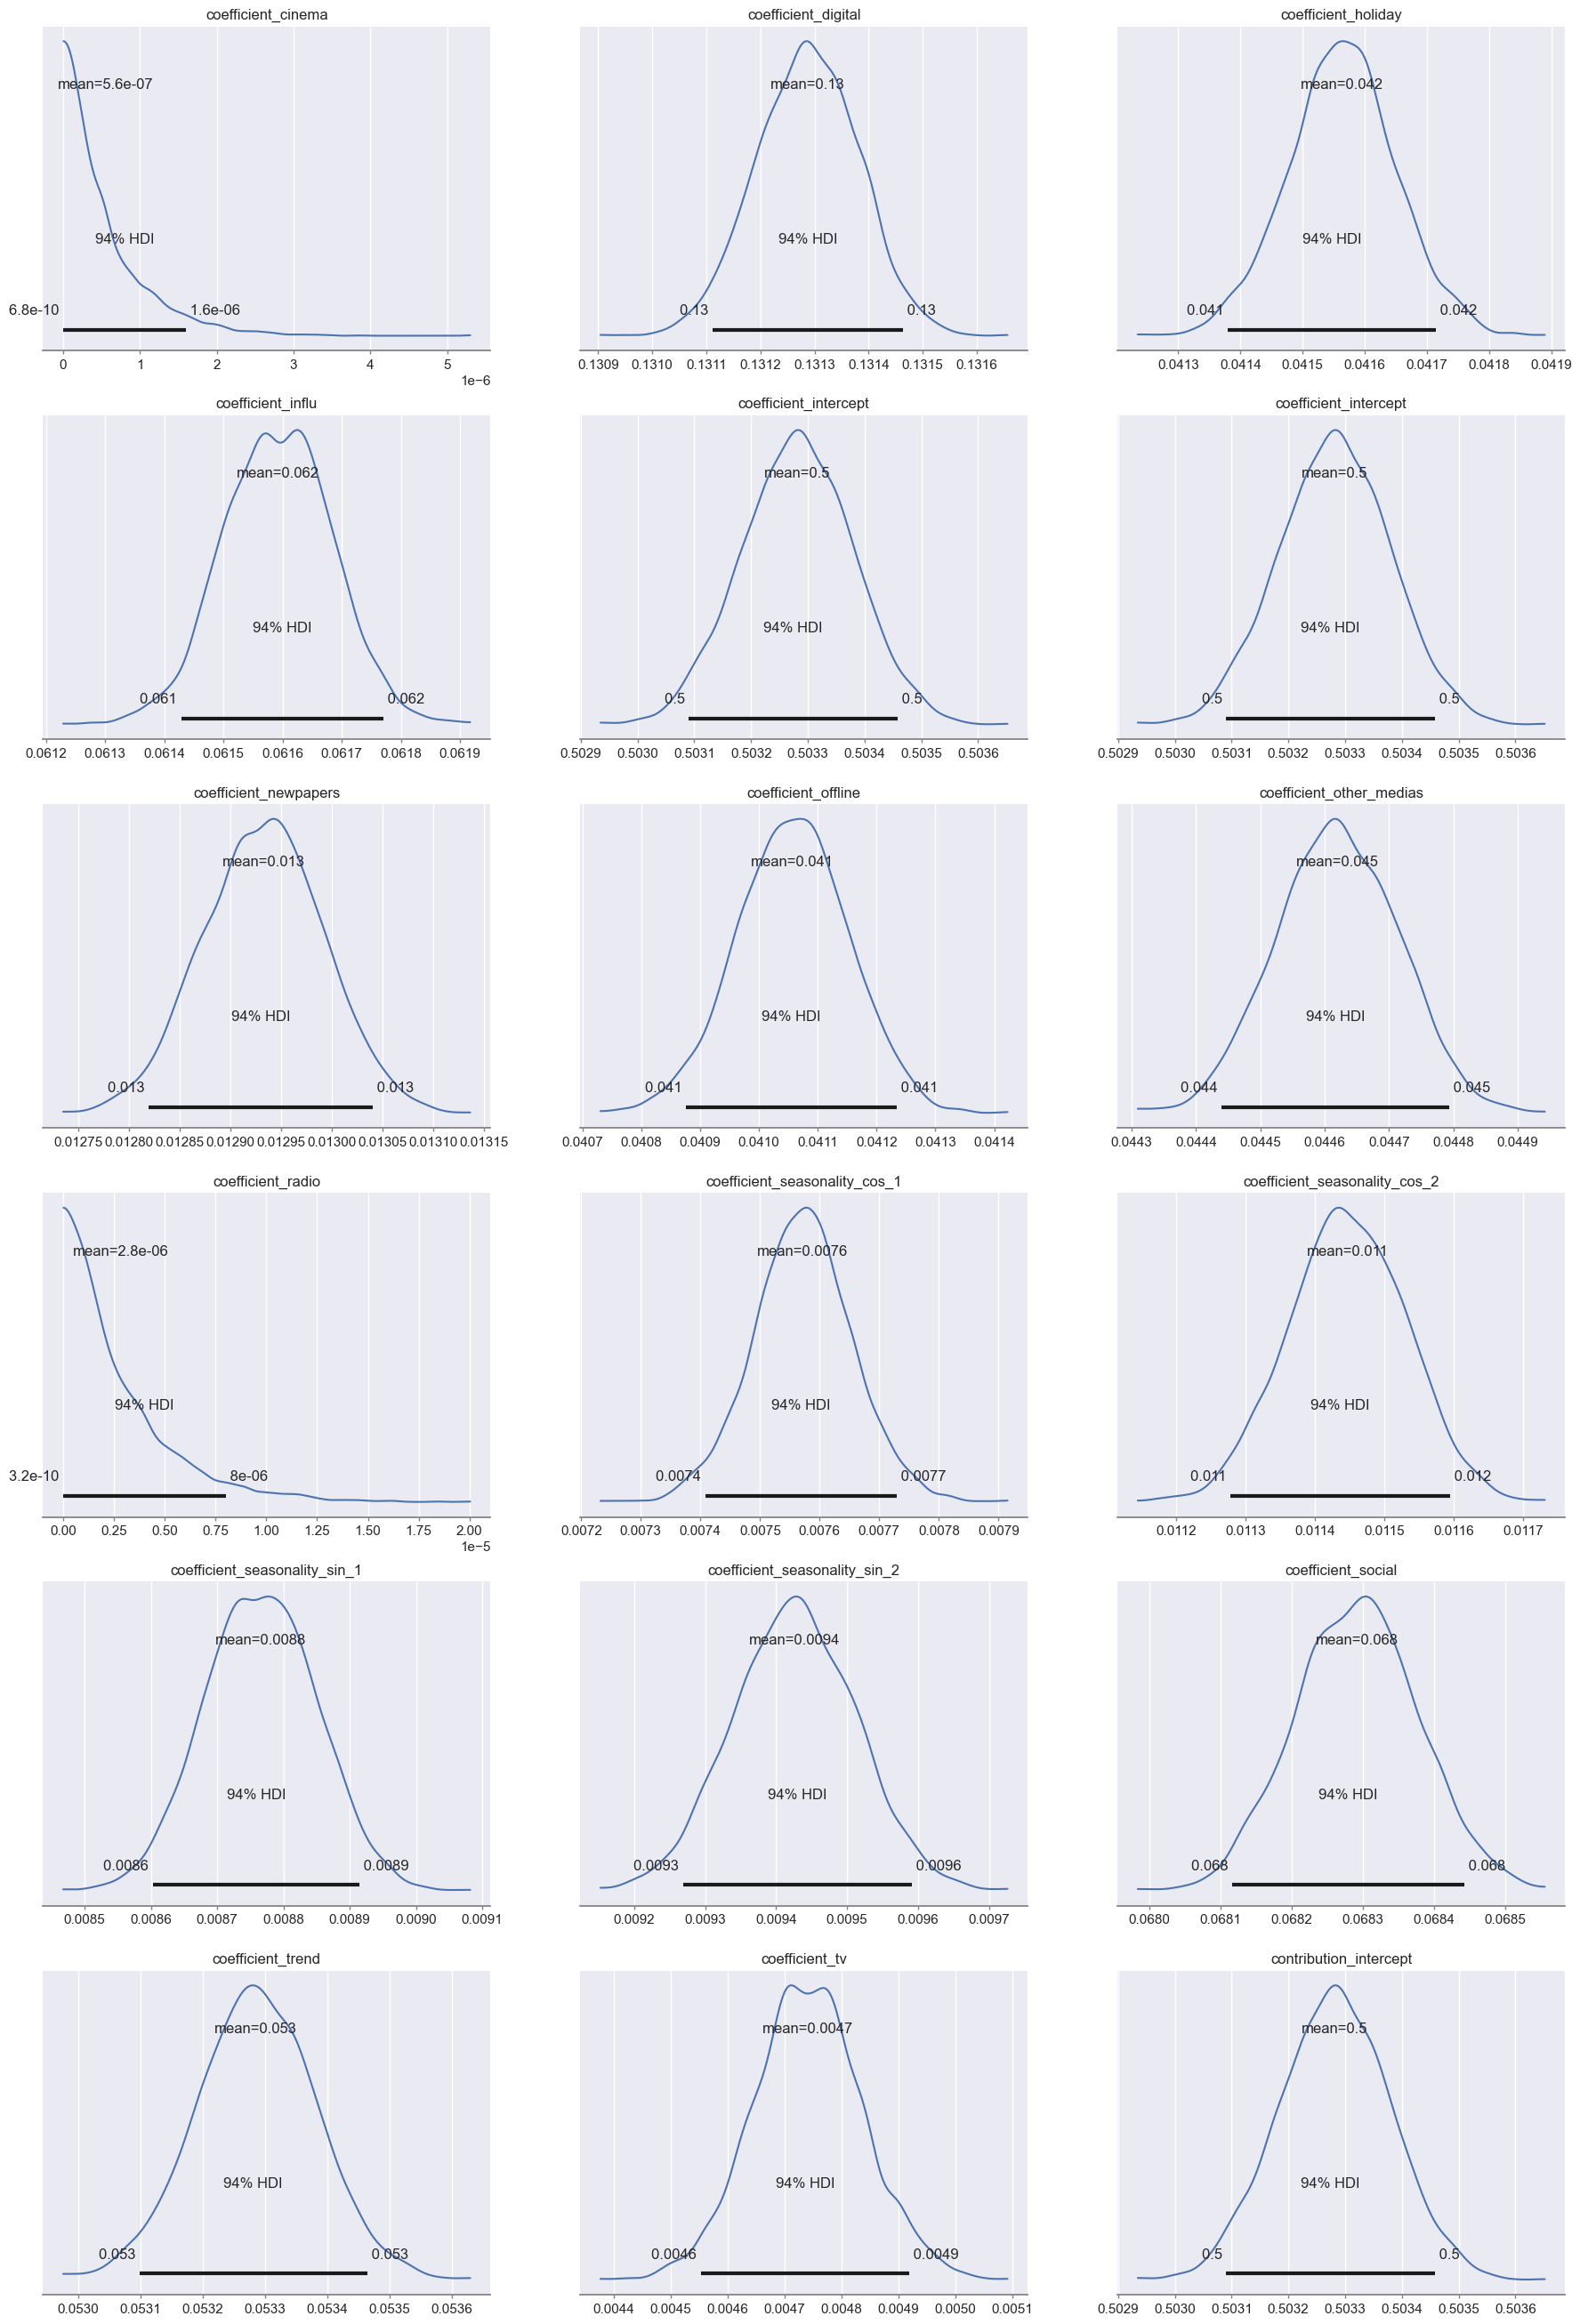

In [14]:
az.plot_posterior(
    trace,
    var_names=['intercept', 'coefficient_'],
    filter_vars='like'
);

In [15]:
trace['posterior']["contribution_cinema"].mean()

<xarray.DataArray 'contribution_cinema' ()> Size: 8B
array(5.56537688e-07)